<a href="https://colab.research.google.com/github/jngamvir/HBN/blob/master/HBN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%matplotlib inline
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from warnings import filterwarnings

import pymc3 as pm
from pymc3 import floatX
import theano
import theano.tensor as tt
from pymc3.theanof import set_tt_rng, MRG_RandomStreams

import sklearn
from sklearn import datasets
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

filterwarnings('ignore')
sns.set_style('white')

set_tt_rng(MRG_RandomStreams(42))

cmap = sns.diverging_palette(250, 12, s=85, l=25, as_cmap=True)
cmap_uncertainty = sns.cubehelix_palette(light=1, as_cmap=True)

layer_names = ['w_in_1_grp', 'w_1_2_grp', 'w_2_out_grp']

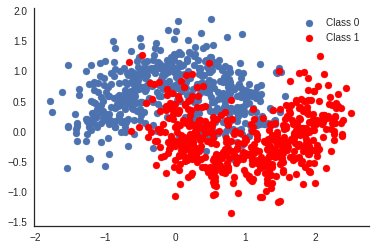

In [2]:
X, Y = make_moons(noise=0.3, n_samples=1000)
plt.scatter(X[Y==0, 0], X[Y==0, 1], label='Class 0')
plt.scatter(X[Y==1, 0], X[Y==1, 1], color='r', label='Class 1')
sns.despine(); plt.legend();

In [0]:
def rotate(X, deg):
    theta = np.radians(deg)
    c, s = np.cos(theta), np.sin(theta)
    R = np.matrix([[c, -s], [s, c]])

    X = X.dot(R)
    
    return np.asarray(X)

In [0]:
np.random.seed(31)

n_samples = 100
n_grps = 18
n_grps_sq = int(np.sqrt(n_grps))
Xs, Ys = [], []
for i in range(n_grps):
    # Generate data with 2 classes that are not linearly separable
    X, Y = make_moons(noise=0.3, n_samples=n_samples)
    X = scale(X)
    X = floatX(X)
    Y = floatX(Y)
    
    # Rotate the points randomly for each category
    rotate_by = np.random.randn() * 90.
    X = rotate(X, rotate_by)
    Xs.append(X)
    Ys.append(Y)
    
Xs = np.stack(Xs)
Ys = np.stack(Ys)

Xs_train = Xs[:, :n_samples // 2, :]
Xs_test = Xs[:, n_samples // 2:, :]
Ys_train = Ys[:, :n_samples // 2]
Ys_test = Ys[:, n_samples // 2:]

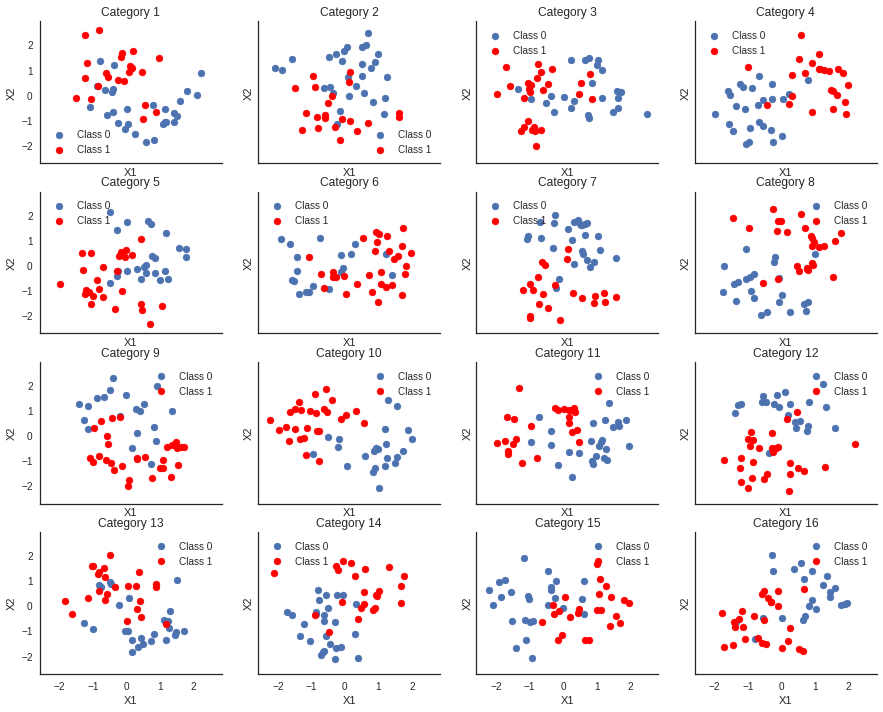

In [5]:
fig, axs = plt.subplots(figsize=(15, 12), nrows=n_grps_sq, ncols=n_grps_sq, 
                        sharex=True, sharey=True)
axs = axs.flatten()
for i, (X, Y, ax) in enumerate(zip(Xs_train, Ys_train, axs)):
    ax.scatter(X[Y==0, 0], X[Y==0, 1], label='Class 0')
    ax.scatter(X[Y==1, 0], X[Y==1, 1], color='r', label='Class 1')
    sns.despine(); ax.legend()
    ax.set(title='Category {}'.format(i + 1), xlabel='X1', ylabel='X2')

In [0]:
def construct_flat_nn(ann_input, ann_output):
    """Function to create a flat BNN given data."""
    n_hidden = 5
    
    # Initialize random weights between each layer
    init_1 = floatX(np.random.randn(X.shape[1], n_hidden))
    init_2 = floatX(np.random.randn(n_hidden, n_hidden))
    init_out = floatX(np.random.randn(n_hidden))
        
    with pm.Model() as neural_network:
        # Weights from input to hidden layer
        weights_in_1 = pm.Normal('w_in_1', 0, sd=1, 
                                 shape=(X.shape[1], n_hidden), 
                                 testval=init_1)
        
        # Weights from 1st to 2nd layer
        weights_1_2 = pm.Normal('w_1_2', 0, sd=1, 
                                shape=(n_hidden, n_hidden), 
                                testval=init_2)
        
        # Weights from hidden layer to output
        weights_2_out = pm.Normal('w_2_out', 0, sd=1, 
                                  shape=(n_hidden,), 
                                  testval=init_out)
        
        # Build neural-network using tanh activation function
        act_1 = pm.math.tanh(pm.math.dot(ann_input, weights_in_1))
        act_2 = pm.math.tanh(pm.math.dot(act_1, weights_1_2))
        act_out = pm.math.dot(act_2, weights_2_out)
        
        # Binary classification -> Bernoulli likelihood
        out = pm.Bernoulli('out', 
                           logit_p=act_out,
                           observed=ann_output)
    return neural_network

In [0]:
def fit_and_eval_bnn(X_train, X_test, Y_train, Y_test, grid, dummy_out, bnn_func, bnn_kwargs=None, sample_kwargs=None):
    """Utility function to create a BNN from a function, sample from it, and create predictions."""
    if bnn_kwargs is None:
        bnn_kwargs = {}
        
    if sample_kwargs is None:
        sample_kwargs = {'chains': 1, 'progressbar': False}
        
    ann_input = theano.shared(X_train)
    ann_output = theano.shared(Y_train)
    model = bnn_func(ann_input, ann_output, **bnn_kwargs)
    
    with model:
        # fit model
        trace = pm.sample(**sample_kwargs)
        # sample posterior predictive
        ppc_train = pm.sample_ppc(trace, samples=500, progressbar=False) 
        
        # Use probability of > 0.5 to assume prediction of class 1
        pred_train = ppc_train['out'].mean(axis=0) > 0.5
        
        # Make predictions on test-set
        ann_input.set_value(X_test)
        ann_output.set_value(Y_test)
        ppc_test = pm.sample_ppc(trace, samples=500, progressbar=False)

        pred_test = ppc_test['out'].mean(axis=0) > 0.5
        
        # Evaluate classifier over grid
        ann_input.set_value(grid)
        ann_output.set_value(dummy_out)
        ppc_grid = pm.sample_ppc(trace, samples=500, 
                                 progressbar=False)['out']
        
    return pred_train, pred_test, ppc_grid, trace

In [8]:
Ys_pred_train = []
Ys_pred_test = []
grid_eval = []

grid = pm.floatX(np.mgrid[-3:3:100j,-3:3:100j])
grid_2d = grid.reshape(2, -1).T
dummy_out = np.ones(grid.shape[1], dtype=np.int8)

for X_train, Y_train, X_test, Y_test in zip(Xs_train, Ys_train, Xs_test, Ys_test):
    pred_train, pred_test, ppc_grid, trace_flat = \
        fit_and_eval_bnn(X_train, X_test, 
                         Y_train, Y_test, 
                         grid_2d, dummy_out, 
                         construct_flat_nn)
    Ys_pred_train.append(pred_train)
    Ys_pred_test.append(pred_test)
    grid_eval.append(ppc_grid)

Ys_pred_train = np.stack(Ys_pred_train)
Ys_pred_test = np.stack(Ys_pred_test)
ppc_grid_single = np.stack(grid_eval)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w_2_out, w_1_2, w_in_1]
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w_2_out, w_1_2, w_in_1]
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w_2_out, w_1_2, w_in_1]
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w_2_out, w_1_2, w_in_1]
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


In [9]:
print ("Train accuracy = {:.2f}%".format(100*np.mean(Ys_pred_train == Ys_train)))

Train accuracy = 87.00%


In [10]:
print ("Test accuracy = {:.2f}%".format(100*np.mean(Ys_pred_test == Ys_test)))

Test accuracy = 83.33%


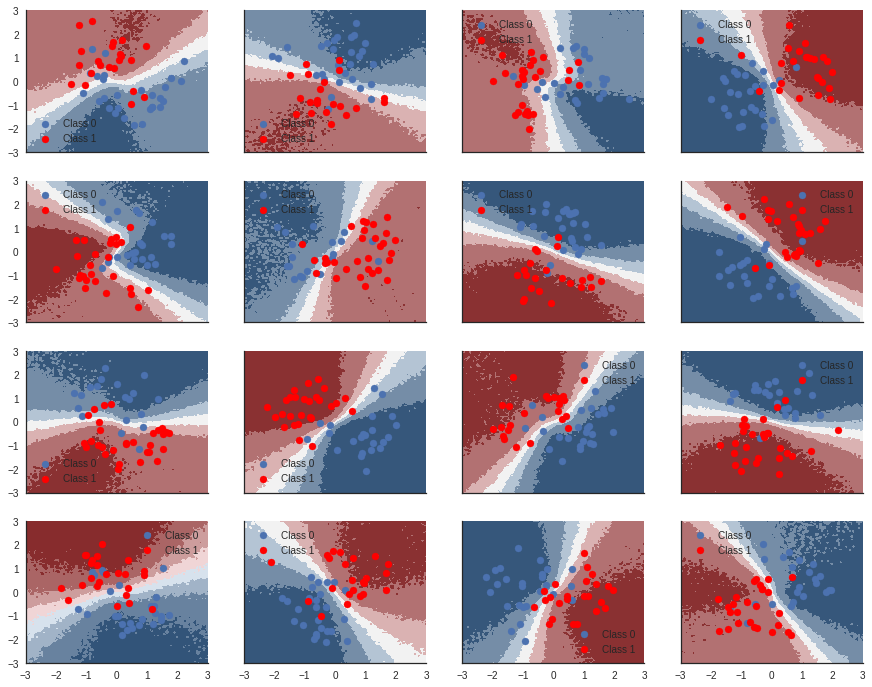

In [11]:
fig, axs = plt.subplots(figsize=(15, 12), nrows=n_grps_sq, ncols=n_grps_sq, sharex=True, sharey=True)
axs = axs.flatten()
for i, (X, Y_pred, Y_true, ax) in enumerate(zip(Xs_train, Ys_pred_train, Ys_train, axs)):
    contour = ax.contourf(grid[0], grid[1], ppc_grid_single[i, ...].mean(axis=0).reshape(100, 100), cmap=cmap)
    ax.scatter(X[Y_true == 0, 0], X[Y_true == 0, 1], label='Class 0')
    ax.scatter(X[Y_true == 1, 0], X[Y_true == 1, 1], color='r', label='Class 1')
    sns.despine(); ax.legend()